# Molecule Alpha Simulations

Repository: https://gitlab.com/linumlabs/molecule-system-modelling

**What do we want to investigate given certain assumptions?**

1. Assuming a buy & hold investment behaviour, what tax rate results in reasonable investor break-even period and reaching the funding goal.
2. Given a certain tax rate, what user base and behaviour is needed to reach funding goal in given period.
3. How can we design the bonding curve such that the funding goal is reached within the given time allocated?
4. How can we design the tax such that investors are rewarded fairly, both early and late?
5. How can we fairly dissolve a project and redistribute its collateral when completed?

**In an ideal efficient market, we hope to:**

1. Reach the funding goal in the given period
2. Reward investors fairly
3. Promote further investment

**Funding outcomes can be any of the following, with certain consequences:**

Market creators
1. Funding reached within time period
2. Funding reached before time period
3. Funding not reached

Investors
1. Investors reach ROI
2. Investors make a profit
3. Investors make a loss

**Given the funding goal and period, what parameters will help us reach that goal?**

1. Tax rate
2. Total investment
3. Investor activity
4. Bonding curve

# Learnings

## Number 1
The variance or sensitivity to a parameter can often tell you a lot more than the raw result of an experiment.
This is especially true in a black-box system or a system where there is large uncertainty surrounding the exogenous inputs or collective behaviour of actors in the system.

# Module imports

In [2]:
import sys
sys.path.append("../venv/lib/python3.7/site-packages")

from cadCAD.configuration.utils import config_sim #env_trigger, var_substep_trigger, config_sim, psub_list
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

# import cadCadFunctions as c2F
from tabulate import tabulate

from matplotlib import cm

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import math
from scipy.optimize import fsolve
import scipy.integrate as integrate
from datetime import timedelta

from decimal import Decimal
import numpy as np
import pandas as pd
from pynverse import inversefunc

import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod
from functools import partial
import random
import uuid
import json

import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='BenjaminScholtz', api_key='8HheLHWEyoXDuLOiQ4ZO')

from helpers import *

%matplotlib inline
%pprint on

Pretty printing has been turned OFF


# Experiment Configuration

In [3]:
# tax_rate_min = widgets.BoundedFloatText(
#     value = .15,
#     min = .05,
#     max = .5,
#     step = .01,
#     description = "Tax rate min: "
# )

# tax_rate_max = widgets.BoundedFloatText(
#     value = .15,
#     min = .05,
#     max = .5,
#     step = .01,
#     description = "Tax rate max: "
# )

# widgets.Box([tax_rate_min, tax_rate_max])

In [4]:
# Global parameters
#####################################################################
projects = 1
max_investors_per_project = 20

default_gradient = 1/20_000.0
default_shift = 0.5

blocks_per_year = 2102400
blocks_per_month = blocks_per_year/12
blocks_per_day = blocks_per_year/365

# Simulation duration
months = 6
time_steps = int(months*30) # approx. 30 days per month

# Investor user base growth
sigmoid_inflection = time_steps/2
sigmoid_slope = 1/20

# Bonding curves
#####################################################################
def linear(x):
    m = 1/20_000.0
    c = 0.5
    return np.multiply(m, x) + c

def negative_exponential(x):
    C = 10
    a = 0.001
    return C * (1 - np.exp(-a*x)) + 1

# Investor behaviour
#####################################################################
def hodl_buy(investment, investor_node, bonding_curve): # Buy and hold
    check_funds = investor_node['trading_balance'] >= investment
    check_initial_investment = investor_node['invested'] == 0 #TODO
    return check_funds and check_initial_investment

def roi_buy(investment, investor_node, bonding_curve): # Buy and wait for ROI
    # Calculate estimated value of investor bonded tokens before trades performed
    estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    check_funds = investor_node['trading_balance'] >= investment
    check_initial_investment = investor_node['invested'] == 0 #TODO
    check_roi = estimated_value > 0 and investor_node['invested'] > 0 and (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']/2
    return (check_funds and check_initial_investment)# or (check_funds and check_roi)

def roi_sell(investment, investor_node, bonding_curve): # Buy and wait for ROI
    # Calculate estimated value of investor bonded tokens before trades performed
    estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    check_sentiment = investor_node['sentiment'] < 1
    check_roi = investor_node['cost_of_investment'] > 0 and (estimated_value - investor_node['cost_of_investment']) / investor_node['cost_of_investment'] > investor_node['desired_roi']
    return check_sentiment and check_roi

# cadCAD Parameter Sets
#####################################################################
# Experiment 1:
# e.g. linear curve, hodl, varying tax rate .15 to .35, 1000.0 dollar investment size

params = {
    'sweep': [1, 2],
    'bonding_function': [
        lambda x: linear(x),
#         lambda x: negative_exponential(x)
    ],
    # 
    'investor_buy_behaviour': [
        lambda investment, investor_node, bonding_curve: hodl_buy(investment, investor_node, bonding_curve),
        lambda investment, investor_node, bonding_curve: roi_buy(investment, investor_node, bonding_curve),
    ],
    'investor_sell_behaviour': [
        lambda investment, investor_node, bonding_curve: False,
        lambda investment, investor_node, bonding_curve: roi_sell(investment, investor_node, bonding_curve),
    ],
    'tax_rate': [
        [.15, .30], # increasing over _time_
        [.15, .30]
    ],
    'investment_size': [
        1000.0,
    ]
}

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps

simulation_parameters = config_sim({
    'T': range(time_steps),
    'N': 1,
    'M': params
})
simulation_parameters

[{'N': 1, 'T': range(0, 180), 'M': {'sweep': 1, 'bonding_function': <function <lambda> at 0x7efec468b048>, 'investor_buy_behaviour': <function <lambda> at 0x7efec46e7ea0>, 'investor_sell_behaviour': <function <lambda> at 0x7efec46e79d8>, 'tax_rate': [0.15, 0.3], 'investment_size': 1000.0}}, {'N': 1, 'T': range(0, 180), 'M': {'sweep': 2, 'bonding_function': <function <lambda> at 0x7efec468b048>, 'investor_buy_behaviour': <function <lambda> at 0x7efec46e7f28>, 'investor_sell_behaviour': <function <lambda> at 0x7efec46e78c8>, 'tax_rate': [0.15, 0.3], 'investment_size': 1000.0}}]

In [5]:
%%latex
$$ f(s) = ms + b $$
$$ \int_s f(s) = \frac{1}{2}ms^2 + bs $$

$$ \int_p f^{-1}(p) = \sqrt{\frac{2*p}{m}} $$
$$ \int_p f^{-1}(p) = \frac{-b + \sqrt{b^2 + 2*m*p}}{m} $$

<IPython.core.display.Latex object>

# Experiment Output

In [6]:
from IPython.display import display, Markdown, Image

import os
import glob
import pprint
pp = pprint.PrettyPrinter(indent=4)

for experiment in params['sweep']:
    display(Markdown('## Experiment %s' % experiment))
    directory = 'experiment_%s/' % experiment
    
    files = filter(os.path.isfile, glob.glob(directory + '*.png'))
    files = sorted(files, key=os.path.getmtime)
    pp.pprint(simulation_parameters[experiment - 1])
    print(files)
    for file in files:
        #fig = pickle.load(open(path, 'rb'))
        #fig.show()
        display(Image(file))

## Experiment 1

{   'M': {   'bonding_function': <function <lambda> at 0x7efec468b048>,
             'investment_size': 1000.0,
             'investor_buy_behaviour': <function <lambda> at 0x7efec46e7ea0>,
             'investor_sell_behaviour': <function <lambda> at 0x7efec46e79d8>,
             'sweep': 1,
             'tax_rate': [0.15, 0.3]},
    'N': 1,
    'T': range(0, 180)}
[]


## Experiment 2

{   'M': {   'bonding_function': <function <lambda> at 0x7efec468b048>,
             'investment_size': 1000.0,
             'investor_buy_behaviour': <function <lambda> at 0x7efec46e7f28>,
             'investor_sell_behaviour': <function <lambda> at 0x7efec46e78c8>,
             'sweep': 2,
             'tax_rate': [0.15, 0.3]},
    'N': 1,
    'T': range(0, 180)}
[]


# User base (contributor) growth

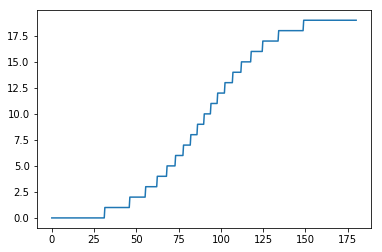

In [7]:
x = np.linspace(0, time_steps, 500)
y = np.divide(max_investors_per_project, (1 + np.power(np.e, -np.multiply(np.subtract(x, sigmoid_inflection), sigmoid_slope))))
y = np.floor(y)
y[y < 0] = 0

plt.plot(x, y)
plt.show()

# Business Logic

In [8]:
# monotonically increasing polynomial function
def bonding_function(x, m=default_gradient, c=default_shift):
    return params['bonding_function'][0](x)

# note: this tax function is just for the basic plots, and is not used in simulation yet
def tax_function(x, m=default_gradient, c=default_shift):
    return np.multiply(m, x) + c*(1 - params['tax_rate'][0][0])
#     C = 10
#     a = 0.001
#     return C * (1 - np.exp(-a*x))

# this is essentially numerical integration
#     return [np.sum(bonding_function(x[:index])) for index,_ in enumerate(x)]

def integral_function(x):
    return integrate.quad(lambda i: bonding_function(i), 0, x)[0]

# invariant function
def collateral_pool(x):
    return [integral_function(x[index]) for index,_ in enumerate(x)]
    
def inverse_integral_function(x):
    func = inversefunc(integral_function)
    return func(x)

def final_collateral(x):
    return integrate.quad(lambda i: bonding_function(i), x[0], x[-1])

def vault_pool(x):
    return np.subtract(collateral_pool(x), [integrate.quad(lambda i: tax_function(i), x[0], x[index])[0] for index,_ in enumerate(x)])

def investor_pool(x):
    return np.subtract(collateral_pool(x), vault_pool(x))

# Contract functions
#####################################################################
def price_to_mint(x_T, total_supply, pool_balance, gradient):
    return max(integral_function(total_supply + x_T) - pool_balance, 0)

def reward_for_burn(x_T, total_supply, pool_balance):
    return max(pool_balance - integral_function(total_supply - x_T), 0)

def collateral_to_token_buying(x_D, total_supply):
    return inverse_integral_function(integral_function(total_supply) + x_D) - total_supply

def collateral_to_token_selling(x_D, total_supply):
    try:
        return total_supply - inverse_integral_function(integral_function(total_supply) - x_D)
    except ValueError:
        return 0

In [9]:
# Sell token holdings
def sell_holdings(investor_node, bonding_curve, value):
    tokens =  min(collateral_to_token_selling(value, bonding_curve['bonded_tokens']), investor_node['bonded_tokens'])
    value = reward_for_burn(tokens, bonding_curve['bonded_tokens'], bonding_curve['reserve'])
    
    assert(tokens >= 0)
    assert(value >= 0)
    
    if bonding_curve['bonded_tokens'] >= tokens and bonding_curve['reserve'] >= value:
        bonding_curve['bonded_tokens'] -= tokens
        bonding_curve['reserve'] -= value
    else: return False
        
    investor_node['trading_balance'] += value
    investor_node['invested'] -= value
    investor_node['bonded_tokens'] -= tokens
    
    assert(investor_node['trading_balance'] >= 0)
    #assert(investor_node['invested'] >= 0)
    assert(investor_node['bonded_tokens'] >= 0)
    
    return True

# Basic Token Economics

In [10]:
x = np.linspace(0,10_000,10_00)

y = bonding_function(x)
t = tax_function(x)
c = collateral_pool(x)
v = vault_pool(x)
i = investor_pool(x)

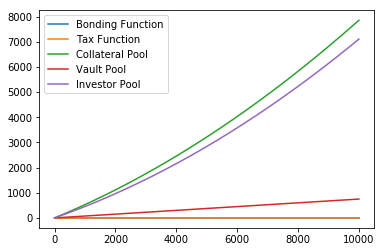

In [10]:
plt.plot(x, y, label='Bonding Function')
plt.plot(x, t, label='Tax Function')
plt.plot(x, c, label='Collateral Pool')
plt.plot(x, v, label='Vault Pool')
plt.plot(x, i, label='Investor Pool')
plt.legend(loc='upper left')
plt.show()

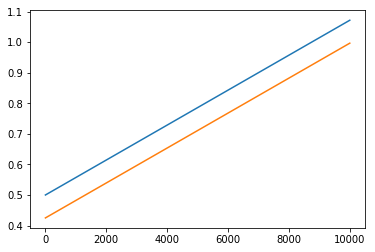

In [11]:
# Bonding function and tax (sell) function
plt.plot(x, y, x, t)
plt.show()

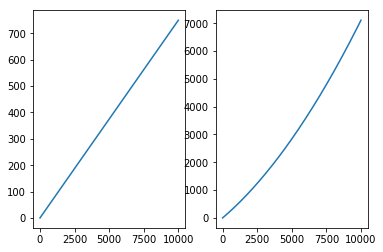

In [12]:
# Vault and investor pool
fig, axs = plt.subplots(1,2)

axs[0].plot(x, v)
axs[1].plot(x, i)

# Network Graph Configuration

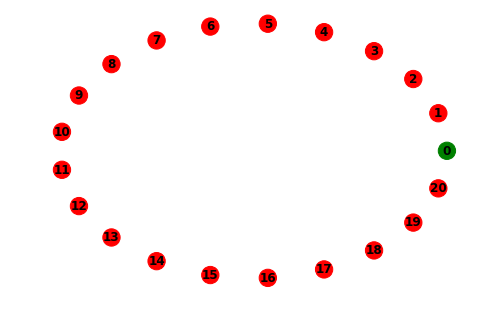

In [13]:
def generate_network(_params=params):
    network = nx.Graph()
    color_map = []

    for index in range(projects):
        color_map.append('green')

        network.add_node(index, _type='project')
        network.nodes[index]['vault'] = {
            'reserve': 0
        }
        network.nodes[index]['bonding_curve'] = {
            'bonded_tokens': 0,
            'reserve': 0
        }
        network.nodes[index]['funding_goal'] = 1_000_000
        network.nodes[index]['funding_period'] = 6
        #network.nodes[index]['tax_rate'] = params['tax_rate'][0]

    for index in range(max_investors_per_project):
        color_map.append('red')
        index = index + projects

        network.add_node(index, _type='investor')
        network.nodes[index]['logs'] = {
            'entry': 0,
            'disinvested': False,
            'check_roi': False,
        }
        network.nodes[index]['trading_balance'] = 10_000
        network.nodes[index]['invested'] = 0
        network.nodes[index]['cost_of_investment'] = 0
        network.nodes[index]['bonded_tokens'] = 0
        network.nodes[index]['estimated_value'] = 0
        network.nodes[index]['sentiment'] = 0
        network.nodes[index]['desired_roi'] = .1 # If sentiment < 1, when estimated_value is greater than invested by more than desired ROI, then sell
        network.nodes[index]['taxed'] = 0
    
    return (network, color_map)

network, color_map = generate_network()
nx.draw_kamada_kawai(network, node_color=color_map, font_weight='bold', with_labels=True) # with_labels=True

# def get_networkx_pickle_file(params, state):
#     return 'pickle/network_%s_%s.pickle' % (params['sweep'], state['timestep'])

# pickle_file = 'pickle/network.pickle'
# nx.write_gpickle(network, pickle_file)

class NetworkState(StateType):
    network = auto()
    
    @classmethod
    def initial_conditions(cls):
        return {
            cls.network: network,
        }

# cadCAD Model Initialization

In [14]:
# ts_format = '%Y-%m-%d %H:%M:%S'
# t_delta = timedelta(days=30, minutes=0, seconds=0)
# def time_model(_g, step, sL, s, _input):
#     y = 'time'
#     x = ep_time_step(s, dt_str=s['time'], fromat_str=ts_format, _timedelta=t_delta)
#     return (y, x)

# exogenous_states = {
# #     'time': time_model
# }
# env_processes = {}

initial_state = {
    'network': network
#     **NetworkState.initial_conditions(),
#     **StateExogenous.initial_conditions(),
#     **StateAgregated.initial_conditions()
}

def _new_investors(_params, step, sL, s, _input):        
        network: nx.Graph = s['network']

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')

        currently_invested = list(network.neighbors(project))
        
        number_of_investors = max_investors_per_project/(1 + math.pow(math.e, -(s['timestep'] - sigmoid_inflection)*sigmoid_slope))
        number_of_investors = max(math.floor(number_of_investors), 0)

        new_investors = investors[len(currently_invested) : number_of_investors]

        for index in new_investors:
            network.add_edge(project, index)
        
        return ('network', network)

def calculate_tax_rate(_params, s):
    tax_rate_min = _params['tax_rate'][0]
    tax_rate_max = _params['tax_rate'][1]
    tax_rate = tax_rate_min + (s['timestep']/time_steps)*(tax_rate_max - tax_rate_min)
    return tax_rate
    
def _perform_trades(_params, step, sL, s, _input):
        network: nx.Graph = s['network']
        
        # Extract nodes from network graph
        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
            
            # Calculate buy tax
            collateral_to_invest = _params['investment_size']
            collateral_tax = collateral_to_invest * calculate_tax_rate(_params, s)
            collateral_less_tax = collateral_to_invest - collateral_tax
                  
            if _params['investor_buy_behaviour'](collateral_to_invest, investor_node, bonding_curve):
                investor_node['logs']['disinvested'] = False
                # Calculate token trade value
                tokens_buy = collateral_to_token_buying(collateral_less_tax, bonding_curve['bonded_tokens'])
                
                # Update system balances
                vault['reserve'] += collateral_tax
                bonding_curve['bonded_tokens'] += tokens_buy
                bonding_curve['reserve'] += collateral_less_tax
                
                # Update investor balances
                investor_node['taxed'] += collateral_tax
                investor_node['trading_balance'] -= collateral_to_invest
                investor_node['invested'] += collateral_less_tax
                investor_node['cost_of_investment'] += collateral_to_invest
                investor_node['bonded_tokens'] += tokens_buy
            
            # Check investor status
            estimated_value = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
            
            # When estimated_value is greater than invested by more than desired ROI, then sell
            if _params['investor_sell_behaviour'](collateral_to_invest, investor_node, bonding_curve):
                # Sell 100% of holdings
                if sell_holdings(investor_node, bonding_curve, estimated_value):
                    investor_node['logs']['disinvested'] = True
            
        return ('network', network)
    
def _update_balances(_params, step, sL, s, _input):
        network: nx.Graph = s['network']

        projects = get_node_ids_of_type(network, 'project')
        project = projects[0]
        investors = get_node_ids_of_type(network, 'investor')
        
        currently_invested = list(network.neighbors(project))
        
        for index in currently_invested:
            project = projects[0]
            
            project_node = network.node[project]
            investor_node = network.node[index]
            
            vault = project_node['vault']
            bonding_curve = project_node['bonding_curve']
            
            # Calculate estimated value of investor bonded tokens after trades performed
            investor_node['estimated_value'] = reward_for_burn(investor_node['bonded_tokens'], bonding_curve['bonded_tokens'], bonding_curve['reserve'])
        
        return ('network', network)
    
def genesis(_params, step, sL, s):
    if s['timestep'] == 0 or s['timestep'] == 1:
        return {'genesis': True}
    else:
        return {'genesis': False}

def _create_network(_params, step, sL, s, _input):
    if _input['genesis']:
        network = generate_network(_params)
        pickle_file = get_networkx_pickle_file(_params, s)
        nx.write_gpickle(network, pickle_file)
        return ('network', pickle_file)
    else:
#         network = s['network']
        return ('', '')

partial_state_update_blocks = [
#     {
#         'policies': {
#             'action': genesis,
#         },
#         'variables': {
#             'network': _create_network,
#         }
#     },
    # Exogenous inputs
    {
        'policies': {},
        'variables': {
            'network': _new_investors,
        }
    },
    {
        'policies': {},
        'variables': {
            'network': _perform_trades,
        }
    },
    {
        'policies': {},
        'variables': {
            'network': _update_balances,
        }
    }
]

# Model Simulation

In [15]:
from cadCAD.configuration import append_configs

append_configs(
    initial_state=initial_state, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters, #dict containing simulation parameters
#     raw_exogenous_states=exogenous_states,
#     env_processes=env_processes
)

In [16]:
# sys.setrecursionlimit(5000)
from cadCAD import configs

exec_mode = ExecutionMode()
exec_context = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=exec_context, configs=configs)
# raw_result, tensor = run.execute() # The `main()` method returns a tuple; its first elements contains the raw results

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1

multi_proc: [<cadCAD.configuration.Configuration object at 0x7f86284e30f0>, <cadCAD.configuration.Configuration object at 0x7f86284e36d8>]
[<cadCAD.configuration.Configuration object at 0x7f86284e30f0>, <cadCAD.configuration.Configuration object at 0x7f86284e36d8>]


# Model Data Analysis

In [17]:
# Choose which experiment parameter configuration to use, integer starting from zero
import os

def select_experiment(i):
    df = pd.DataFrame(results[i - 1]['result'])
    directory = './experiment_%s/' % i
    if not os.path.exists(directory):
        os.makedirs(directory)
    return df[df.substep==3].copy()

def save_experiment(fig, experiment, name):
    pickle.dump(fig, open('experiment_%s/%s.pickle' % (experiment, name), 'wb'))
    fig.savefig('experiment_%s/%s.png' % (experiment, name))

## Plot of bonding curve collateral vs. vault collateral

In [20]:
for experiment in params['sweep']:
    rdf = select_experiment(experiment)
    rdf['vault_reserve'] = rdf['network'].apply(lambda g: np.array([g.node[j]['vault']['reserve'] for j in get_node_ids_of_type(g, 'project')]))
    rdf['bonding_curve_reserve'] = rdf['network'].apply(lambda g: np.array([g.node[j]['bonding_curve']['reserve'] for j in get_node_ids_of_type(g, 'project')]))

    fig = plt.figure(1,figsize=(20,10)) 
    plt.plot(rdf.timestep, rdf['vault_reserve'])
    plt.plot(rdf.timestep, rdf['bonding_curve_reserve'])
    plt.title('Reserve')
    plt.ylabel('Value ($)')
    plt.xlabel('Time (days)')
    plt.legend(['Vault', 'Bonding Curve'], ncol = 2)

    save_experiment(fig, experiment, 'bonding_vs_vault_collateral')
    plt.close()

## Plot of investor net asset valuation over time

In [21]:
def investor_nav(g):
    projects = get_node_ids_of_type(g, 'project')
    project = projects[0]
    
    project_node = g.node[project]
    vault = project_node['vault']
    bonding_curve = project_node['bonding_curve']

    result = []
    for j in get_node_ids_of_type(g, 'investor'):
#         (estimated_value - investor_node['invested']) / investor_node['invested'] > investor_node['desired_roi']
        nav = g.node[j]['estimated_value'] + g.node[j]['trading_balance'] # g.node[j]['estimated_value'] + g.node[j]['trading_balance'] # g.node[j]['logs']['disinvested'] # 
#         print(g.node[j]['logs']['entry'])
        result.append(nav)       
    return result

# node_sizes = np.append([0], np.divide(rdf['investor_balance'][time_steps], 10))
# plt.figure(1,figsize=(12,12)) 
# nx.draw_circular(df[NetworkState.network][time_steps*3], node_color=color_map, node_size=node_sizes, font_weight='bold', with_labels=True) # with_labels=True

# print(type(df[NetworkState.network]))
# df = pd.DataFrame(raw_result)
# print(df[NetworkState.network].apply(lambda g: g.nodes))

In [22]:
for experiment in params['sweep']:
    rdf = select_experiment(experiment)
    rdf['investor_nav'] = rdf['network'].apply(lambda g: investor_nav(g))

    fig = plt.figure(1,figsize=(20,10))
    data = make2D('investor_nav', rdf)
    plt.plot(rdf.timestep, data)
    plt.axhline(y=10_000, color='r', linestyle='-')
    plt.title('Net asset valuation by investor')
    plt.xlabel('time ($t$)')
    plt.ylabel('valuation ($)')

    save_experiment(fig, experiment, 'net_asset_valuation')
    plt.close()

# Collateral Redistribution

## Observations

`spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']`

1. If you redistribute with a flat spot price, no one makes a profit

In [23]:
network = rdf['network'][time_steps*3]
projects = get_node_ids_of_type(network, 'project')
project = projects[0]
project_node = network.node[project]
vault = project_node['vault']
bonding_curve = project_node['bonding_curve']

def redistribution(network):
    projects = get_node_ids_of_type(network, 'project')
    project = projects[0]
    project_node = network.node[project]
    vault = project_node['vault']
    bonding_curve = project_node['bonding_curve']
    
    if bonding_curve['bonded_tokens'] > 0:
        spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']
    else: spot_price = 0
        
        # (network.node[j]['bonded_tokens']/bonding_curve['bonded_tokens'])*vault['reserve']
    
    result = []
    for j in get_node_ids_of_type(network, 'investor'):
        vault_share = network.node[j]['taxed']
        vault['reserve'] -= vault_share
        if vault['reserve'] < 0:
            print("Oh dear...")
#         vault_share = 0
        balance = (network.node[j]['bonded_tokens']*spot_price + network.node[j]['trading_balance']) - 10_000 # vault_share
        result.append(balance)      
    return result

In [24]:
for experiment in params['sweep']:
    rdf = select_experiment(experiment)
    
    network = rdf['network'][time_steps*3]
    projects = get_node_ids_of_type(network, 'project')
    project = projects[0]
    project_node = network.node[project]
    vault = project_node['vault']
    bonding_curve = project_node['bonding_curve']
    
    result = redistribution(network)
    
    print(bonding_curve)
    spot_price = bonding_curve['reserve']/bonding_curve['bonded_tokens']
    print('Spot price: %s' % spot_price)
    percent_roi = sum(i > 0 for i in result)/len(result)*100
    print('Percent ROI: %s' % percent_roi)
    
    sns.set(style="white", palette="muted", color_codes=True)

    # Set up the matplotlib figure
    fig, axes = plt.subplots(2, figsize=(7, 7), sharex=True)
    sns.despine(left=True)

    # Generate a random univariate dataset
    d = result

    # Plot a kernel density estimate and rug plot
    sns.distplot(d, hist=False, rug=True, color="r", ax=axes[0])

    # Plot a historgram and kernel density estimate
    sns.distplot(d, color="m", ax=axes[1])

    plt.setp(axes, yticks=[])
    plt.tight_layout()

    save_experiment(fig, experiment, 'collateral_redistribution')
    plt.close()

Oh dear...
Oh dear...
{'bonded_tokens': 15562.976637048083, 'reserve': 14701.666666666668}
Spot price: 0.9446564760412836
Percent ROI: 15.0
Oh dear...
Oh dear...
{'bonded_tokens': 10131.879112903489, 'reserve': 7998.938823837171}
Spot price: 0.789482260368671
Percent ROI: 30.0


## ROI Distribution Heatmap

Creating mesh grid
Calculating valuations
Creating surface
Plotting figure


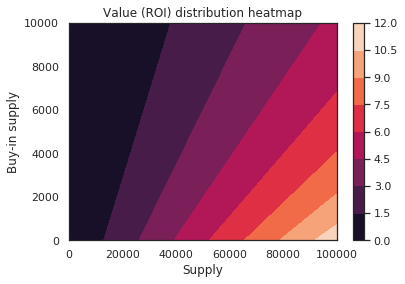

In [30]:
print("Creating mesh grid")

s = np.linspace(0, 100000, 100)
p = np.linspace(0, 10000, 100)

X, Y = np.meshgrid(s, p)

print("Calculating valuations")

buy_in = 1 # dai

def valuation(current_supply, buy_in_supply):
    token_reward = collateral_to_token_selling(buy_in, buy_in_supply)
    pool_balance = integral_function(current_supply)
    valuation = reward_for_burn(token_reward, current_supply, pool_balance)
    return max(0, (valuation - buy_in)/buy_in)

np_func = np.frompyfunc(valuation, 2, 1)

Z = np.nan_to_num(np_func(X, Y))

print("Creating surface")

surface = go.Surface(x=X, y=Y, z=Z)
data = [surface]

layout = go.Layout(
    title='Valuation Plot',
    scene=dict(
        xaxis=dict(
            title='Supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            title='Buy-in supply',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            title='ROI %',
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    )
)

print("Plotting figure")

plt.contourf(X,Y,Z)
plt.colorbar()
plt.title('Value (ROI) distribution heatmap')
plt.xlabel('Supply')
plt.ylabel('Buy-in supply')
plt.savefig('Value (ROI) distribution heatmap.png')
plt.show()